#Setting up JVM

In [ ]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libxtst6 amd64 2:1.2.3-1 [12.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 openjdk-8-jre-headless amd64 8u372-ga~us1-0ubuntu1~20.04 [28.3 MB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 openjdk-8-jdk-headless amd64 8u372-ga~us1-0ubuntu1~20.04 [8,282 kB]
Fetched 

#Installing Apache Spark 3.0.1 with Hadoop 2.7

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2023-05-18 20:21:46--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  19.2MB/s    in 15s     

2023-05-18 20:22:02 (17.8 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



#Unzipping the folder

In [ ]:
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

#Install findspark library

In [ ]:
!pip install -q findspark

#Setting up the environment path and importing findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

#Import and create Spark Session

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Big_Data_Assessment")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

#printing spark variable

spark

#Loading the data set

In [ ]:
ad_clicks_df = spark.read.csv("/content/ad-clicks.csv", header=True, inferSchema=True)
buy_clicks_df = spark.read.csv("/content/buy-clicks.csv", header=True, inferSchema=True)
game_clicks_df = spark.read.csv("/content/game-clicks.csv", header=True, inferSchema=True)
level_events_df = spark.read.csv("/content/level-events.csv", header=True, inferSchema=True)
team_assignments_df = spark.read.csv("/content/team-assignments.csv", header=True, inferSchema=True)
team_df = spark.read.csv("/content/team.csv", header=True, inferSchema=True)
user_session_df = spark.read.csv("/content/user-session.csv", header=True, inferSchema=True)
users_df = spark.read.csv("/content/users.csv", header=True, inferSchema=True)
combined_data_df = spark.read.csv("/content/combined-data.csv", header=True, inferSchema=True)

#Classifier

In [ ]:
from pyspark.sql.functions import col, when

# Filter out rows with avg_price = "NULL"
filtered_df = combined_data_df.filter(col("avg_price") != "NULL")

# Create the "Spender_NonSpender" column
transformed_df = filtered_df.withColumn("Spender_NonSpender", when(col("avg_price") > 5.0, 1).otherwise(0))

# Count the occurrences of 1 and 0 in the transformed column
count_of_ones = transformed_df.filter(col("Spender_NonSpender") == 1).count()
count_of_zeros = transformed_df.filter(col("Spender_NonSpender") == 0).count()

# Print the count
print("Count of 1:", count_of_ones)
print("Count of 0:", count_of_zeros)

# Select the desired columns
#transformed_df = transformed_df.select('teamLevel', 'platformType', 'Spender_NonSpender', 'count_hits', 'count_gameclicks')




# Show the transformed DataFrame
transformed_df.show()


Count of 1: 575
Count of 0: 836
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|Spender_NonSpender|
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+
|   937|         5652|        1|     android|              39|         0|          1|        1|                 0|
|  1623|         5659|        1|      iphone|             129|         9|          1|       10|                 1|
|    83|         5661|        1|     android|             102|        14|          1|        5|                 0|
|   121|         5665|        1|     android|              39|         4|          1|        3|                 0|
|   462|         5666|        1|     android|              90|        10|          1|        3|                 0|
|   819|         5679|        1|      iphone|   

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer


# Create an indexer
indexer = StringIndexer(inputCol='platformType', outputCol='platformType_indexed')

# Indexer identifies categories in the data
indexer_model = indexer.fit(transformed_df)

# Indexer creates a new column with numeric index values
indexed_df= indexer_model.transform(transformed_df)
#indexed_df.show()

DT_df = indexed_df.select('teamLevel','platformType_indexed', 'count_hits','Spender_NonSpender')                                   

# Show the transformed DataFrame
DT_df.show()  



# Prepare features vector using VectorAssembler
featuresUsed = ["count_hits",
 'teamLevel',
"platformType_indexed"
 ]


#Prepare features using VectorAssembler
assembler = VectorAssembler(inputCols=featuresUsed,  outputCol='features')
assembled_df = assembler.transform(DT_df)

# Split the data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed= 17)
train_data.show()



+---------+--------------------+----------+------------------+
|teamLevel|platformType_indexed|count_hits|Spender_NonSpender|
+---------+--------------------+----------+------------------+
|        1|                 1.0|         0|                 0|
|        1|                 0.0|         9|                 1|
|        1|                 1.0|        14|                 0|
|        1|                 1.0|         4|                 0|
|        1|                 1.0|        10|                 0|
|        1|                 0.0|         8|                 1|
|        1|                 1.0|         6|                 0|
|        1|                 1.0|         5|                 0|
|        1|                 1.0|         7|                 0|
|        1|                 0.0|         6|                 1|
|        1|                 1.0|         7|                 0|
|        1|                 0.0|         7|                 1|
|        1|                 1.0|         2|            

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier(labelCol='Spender_NonSpender')
tree_model = tree.fit(train_data)

# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(test_data)
prediction.select('Spender_NonSpender', 'prediction', 'probability').show(5, False)

# Create a confusion matrix
prediction.groupBy('Spender_NonSpender', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND Spender_NonSpender = prediction').count()
TP = prediction.filter('prediction = 1 AND Spender_NonSpender = prediction').count()
FN = prediction.filter('prediction = 1 AND Spender_NonSpender = 0').count()
FP = prediction.filter('prediction = 0 AND Spender_NonSpender= 1').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+------------------+----------+----------------------------------------+
|Spender_NonSpender|prediction|probability                             |
+------------------+----------+----------------------------------------+
|1                 |1.0       |[0.0,1.0]                               |
|1                 |1.0       |[0.22093023255813954,0.7790697674418605]|
|1                 |1.0       |[0.22093023255813954,0.7790697674418605]|
|1                 |1.0       |[0.22093023255813954,0.7790697674418605]|
|1                 |1.0       |[0.22093023255813954,0.7790697674418605]|
+------------------+----------+----------------------------------------+
only showing top 5 rows

+------------------+----------+-----+
|Spender_NonSpender|prediction|count|
+------------------+----------+-----+
|                 1|       0.0|   14|
|                 0|       0.0|  166|
|                 1|       1.0|   84|
|                 0|       1.0|   16|
+------------------+----------+-----+

0.89285714285

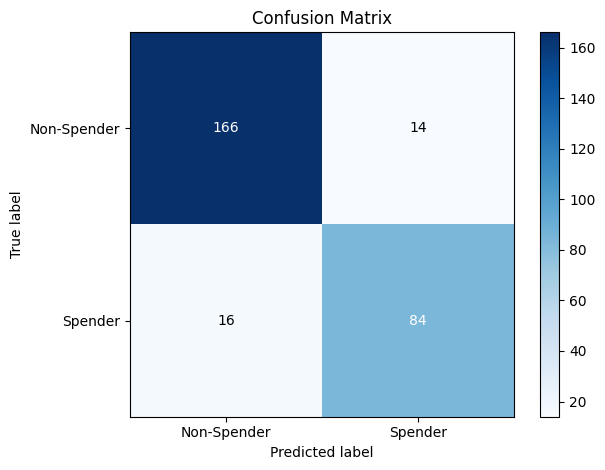

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the confusion matrix values
confusion_matrix_values = np.array([[TN, FP], [FN, TP]])

# Set the labels for the confusion matrix
labels = ['Non-Spender', 'Spender']

# Create the confusion matrix plot
plt.imshow(confusion_matrix_values, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Add text annotations to the confusion matrix
thresh = confusion_matrix_values.max() / 2.
for i in range(confusion_matrix_values.shape[0]):
    for j in range(confusion_matrix_values.shape[1]):
        plt.text(j, i, format(confusion_matrix_values[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion_matrix_values[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


#Logistic Regression

In [ ]:

from pyspark.ml.classification import LogisticRegression

# Selecting numeric columns
# Create an assembler object
featuresUsed = ["count_hits",
 'teamLevel',
"platformType_indexed"
 ]


assembler = VectorAssembler(inputCols=featuresUsed,  outputCol='features')
assembled = assembler.transform(DT_df)

# Split into training and test sets in a 80:20 ratio
train_data, test_data = assembled.randomSplit([0.8, 0.2], seed=17)

# Create classifier object and train on training data
logistic = LogisticRegression(labelCol='Spender_NonSpender').fit(train_data)

# Create a predictions for the test data and show confusion matrix
prediction = logistic.transform(test_data)
prediction.groupBy("Spender_NonSpender", "prediction").count().show()


+------------------+----------+-----+
|Spender_NonSpender|prediction|count|
+------------------+----------+-----+
|                 1|       0.0|   12|
|                 0|       0.0|  168|
|                 1|       1.0|   86|
|                 0|       1.0|   14|
+------------------+----------+-----+



In [ ]:
# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND Spender_NonSpender = prediction').count()
TP = prediction.filter('prediction = 1 AND Spender_NonSpender = prediction').count()
FN = prediction.filter('prediction = 1 AND Spender_NonSpender = 0').count()
FP = prediction.filter('prediction = 0 AND Spender_NonSpender= 1').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)


0.9071428571428571


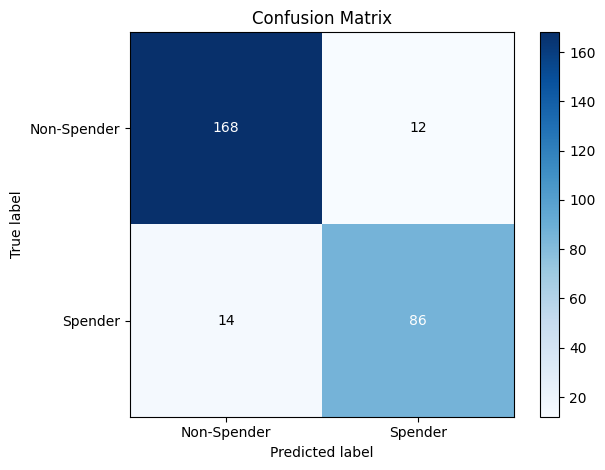

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the confusion matrix values
confusion_matrix_values = np.array([[TN, FP], [FN, TP]])

# Set the labels for the confusion matrix
labels = ['Non-Spender', 'Spender']

# Create the confusion matrix plot
plt.imshow(confusion_matrix_values, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Add text annotations to the confusion matrix
thresh = confusion_matrix_values.max() / 2.
for i in range(confusion_matrix_values.shape[0]):
    for j in range(confusion_matrix_values.shape[1]):
        plt.text(j, i, format(confusion_matrix_values[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion_matrix_values[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()
